In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import psycopg2

**Контекст.**

Перед вами схема данных проекта Тинькофф квест. Постройте воронку, которая показывала бы в динамике по неделям и месяцам, сколько клиентов посещает наш сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

Какие выводы можно сделать исходя из построенной воронки?

In [2]:
DB_ARGS = {
    'database': 'postgres',
    'host': '158.160.52.106',
    'user': 'student',
    'password': 'JvLda93aA',
    'port' : 5432
}

class PostgresConnector(object):
    """

    """
    def __init__(self, db_args=DB_ARGS):
        self._args = db_args

    def send_sql_query(self, query: str):
        conn = psycopg2.connect(**self._args)
        try:
            cursor = conn.cursor()
            cursor.execute(query)
            conn.commit()
        except (Exception, psycopg2.Error) as error:
            print('Error while fetching data from PostgreSQL', error)
        finally:
            if conn:
                cursor.close()
                conn.close()

    def get_df_from_query(self, query: str):
        conn = psycopg2.connect(**self._args)
        df = pd.read_sql(query, conn)
        conn.close()
        return df

In [3]:
connector = PostgresConnector()

querry = '''

 SELECT c.client_rk,
	     c.visit_dttm::DATE AS visit_dt,
       DATE_TRUNC('month', visit_dttm)::DATE AS visit_month,
       DATE_TRUNC('week', visit_dttm)::DATE AS visit_week,
	     MAX(CASE WHEN registration_dttm::date IS NOT NULL THEN 1 ELSE 0 END) AS is_registered,
	     MAX(CASE WHEN application_dttm::date IS NOT NULL THEN 1 ELSE 0 END) AS is_applied,
	     MAX(CASE WHEN game_flg=1 THEN 1 ELSE 0 END) AS is_played
FROM msu_analytics.client AS c 
	  LEFT JOIN msu_analytics.account AS a 
		    USING(client_rk)
	  LEFT JOIN msu_analytics.application AS ap
        USING(account_rk)
	  LEFT JOIN msu_analytics.game AS g 
        USING(game_rk)
GROUP BY 1, 2, 3, 4  
         '''

df = connector.get_df_from_query(querry)

<ipython-input-2-c54af8e45d3c>:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [4]:
print(df.shape)
df.sample(10)

(4096, 7)


,client_rk,visit_dt,visit_month,visit_week,is_registered,is_applied,is_played
1385,3272,2022-11-01,2022-11-01,2022-10-31,0,0,0
742,2453,2023-01-22,2023-01-01,2023-01-16,0,0,0
1658,3972,2022-12-18,2022-12-01,2022-12-12,0,0,0
510,2129,2022-12-22,2022-12-01,2022-12-19,0,0,0
3785,3677,2022-10-21,2022-10-01,2022-10-17,0,0,0
676,3045,2022-12-14,2022-12-01,2022-12-12,0,0,0
2445,959,2022-09-16,2022-09-01,2022-09-12,1,1,0
42,3117,2022-10-02,2022-10-01,2022-09-26,0,0,0
639,1698,2023-01-26,2023-01-01,2023-01-23,1,0,0
93,2250,2023-01-17,2023-01-01,2023-01-16,0,0,0


In [5]:
df['visit_dt'] = pd.to_datetime(df['visit_dt'])
df['visit_month'] = pd.to_datetime(df['visit_month'])
df['visit_week'] = pd.to_datetime(df['visit_week'])

In [6]:
aggs = {
    'client_rk': 'count',
    'is_registered': 'mean',
    'is_applied': 'mean',
    'is_played': 'mean',
}

weeks = df.groupby('visit_week').agg(aggs)
months = df.groupby('visit_month').agg(aggs)

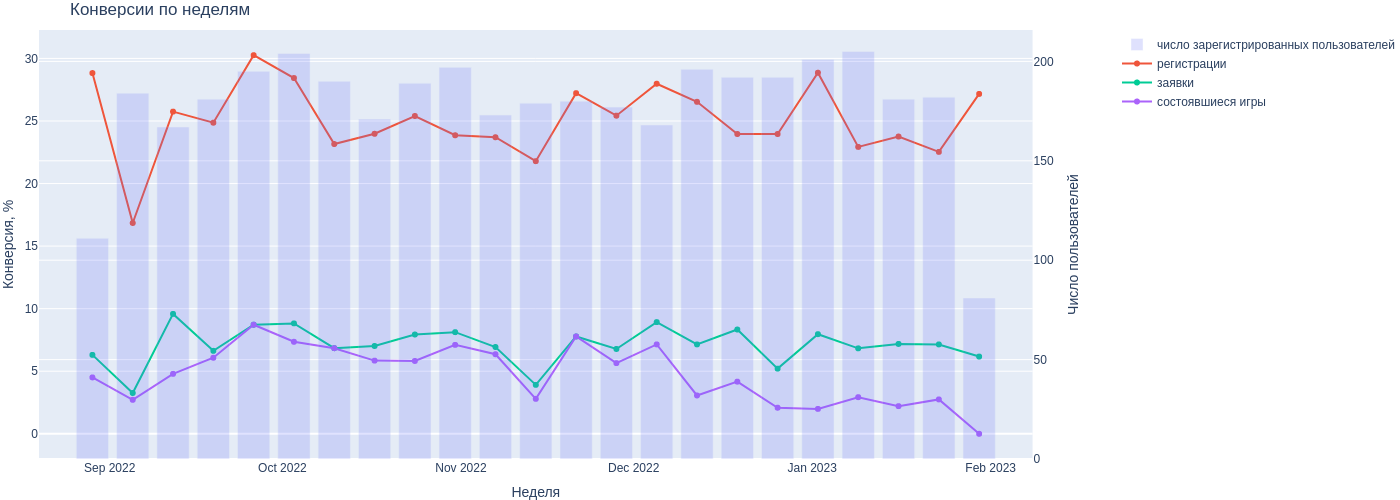

In [7]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.update_layout(
    title='Конверсии по неделям',
    xaxis_title='Неделя',
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.update_yaxes(title_text='Конверсия, %', secondary_y=False)
fig.update_yaxes(title_text='Число пользователей', secondary_y=True)

fig.add_trace(
    go.Bar(
        x=weeks.index, 
        y=weeks['client_rk'],
        opacity=0.2,
        name='число зарегистрированных пользователей'
        ),
    secondary_y=True
    )

fig.add_trace(
    go.Scatter(
        x=weeks.index, 
        y=100*weeks['is_registered'], 
        mode='lines+markers',
        name='регистрации',
        )
    )

fig.add_trace(
    go.Scatter(
        x=weeks.index, 
        y=100*weeks['is_applied'],
        mode='lines+markers',
        name='заявки',
               )
    )
fig.add_trace(
    go.Scatter(
        x=weeks.index, 
        y=100*weeks['is_played'],
        mode='lines+markers',
        name = 'состоявшиеся игры',
        )
    )

# для того чтобы график можно было увидеть на гитхабе
fig.show(
    renderer='png',
    width=1400
    )

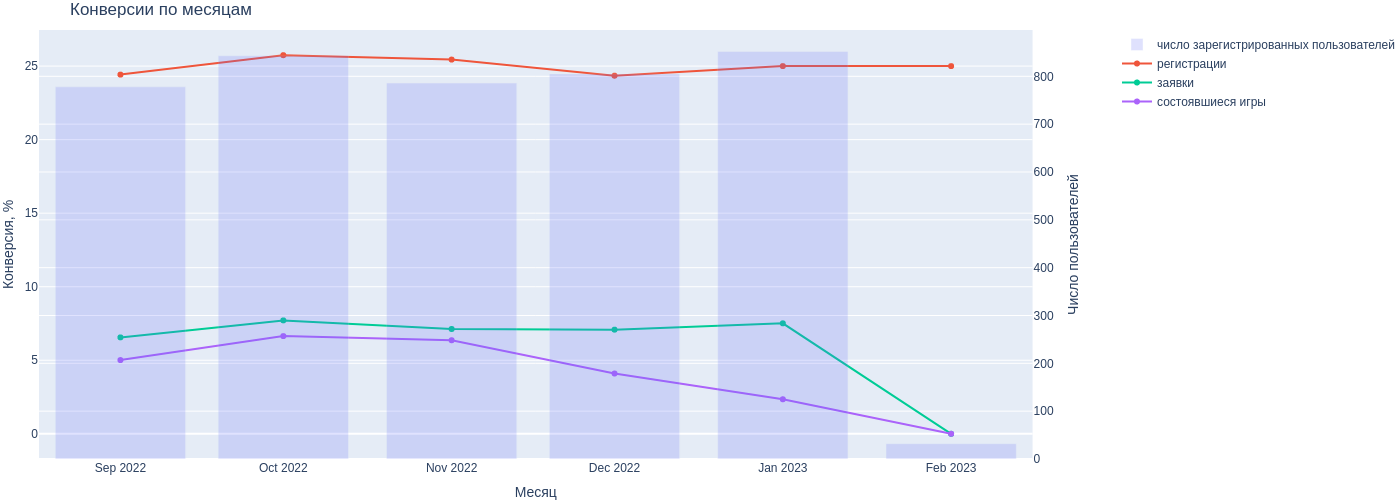

In [8]:
fig = make_subplots(specs=[[{'secondary_y': True}]])

fig.update_layout(
    title='Конверсии по месяцам',
    xaxis_title='Месяц',
    margin=dict(l=0, r=0, t=30, b=0),
)

fig.update_yaxes(title_text='Конверсия, %', secondary_y=False)
fig.update_yaxes(title_text='Число пользователей', secondary_y=True)

fig.add_trace(
    go.Bar(
        x=months.index, 
        y=months['client_rk'],
        opacity=0.2,
        name='число зарегистрированных пользователей'
        ),
    secondary_y=True
    )

fig.add_trace(
    go.Scatter(
        x=months.index, 
        y=100*months['is_registered'], 
        mode='lines+markers',
        name='регистрации',
        )
    )

fig.add_trace(
    go.Scatter(
        x=months.index, 
        y=100*months['is_applied'],
        mode='lines+markers',
        name='заявки',
               )
    )
fig.add_trace(
    go.Scatter(
        x=months.index, 
        y=100*months['is_played'],
        mode='lines+markers',
        name = 'состоявшиеся игры',
        )
    )

# для того чтобы график можно было увидеть на гитхабе
fig.show(
    renderer='png',
    width=1400
    )

Некоторые выводы:

1. Процент регистраций не растет и держится в районе 25%. 
2. Число посещений тоже не растет.
3. Плохая конверсия из регистрации в заявку
4. Резкое падение регистраций на второй неделе. Что-то сломалось?
5. В середине ноября что-то случилось и резко упала а потом вернулась к прежнему уровню доля регистраций. 
6. С сентября по декабрь хорошая конверсия из заявки в игру. Начиная с декабря доля состоявшихся игр начала падать. Возможно из-за нового года.
7. По февралю еще нет данных, поэтому там падение.

